# FAO Production and Coffee Prices — Integrated EDA

This notebook explores the relationship between coffee production dynamics (harvested area, output, and yield) and historical price behavior. FAOSTAT data are aggregated at the annual level and merged with yearly median coffee prices, enabling a consistent temporal comparison across producing countries.


In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter


# Data Import

In [38]:
df_fao=pd.read_csv('data/faodata.csv')
df_fao = (
    df_fao
    .pivot_table(
        index=["Area", "Year"],
        columns="Element",
        values="Value"
    )
    .reset_index()
)
df_fao

Element,Area,Year,Area harvested,Production,Yield
0,Brazil,1961,4383820.0,2228704.00,508.4
1,Brazil,1962,4462657.0,2190303.00,490.8
2,Brazil,1963,4286129.0,1650527.00,385.1
3,Brazil,1964,3696281.0,1042013.00,281.9
4,Brazil,1965,3511079.0,2294047.00,653.4
...,...,...,...,...,...
467,World,2019,11749101.0,10358649.66,881.7
468,World,2020,12064556.0,11233733.88,931.1
469,World,2021,12088063.0,10488327.40,867.7
470,World,2022,12039247.0,10733909.02,891.6


In [39]:
df_prices=pd.read_csv('data/prices.csv',sep=';')
df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m/%d/%Y")


df_prices["Value"] = (
    df_prices["Value"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)

df_prices["month"] = df_prices["Date"].dt.month
df_prices["year"] = df_prices["Date"].dt.year

df_prices

,Date,Value,month,year
0,1969-06-02,0.3725,6,1969
1,1969-06-03,0.3725,6,1969
2,1969-06-04,0.3725,6,1969
3,1969-06-05,0.3725,6,1969
4,1969-06-06,0.3725,6,1969
...,...,...,...,...
14320,2025-12-24,3.4497,12,2025
14321,2025-12-25,3.4510,12,2025
14322,2025-12-26,3.4836,12,2025
14323,2025-12-29,3.5115,12,2025


In [40]:
df_prices_yearly = (
    df_prices
    .groupby("year", as_index=False)
    .agg(price_median=("Value", "median"))
)

Annual prices are aggregated using the median to reduce the influence of extreme short-term price spikes, which are common in commodity markets.


In [41]:
print(
    df_prices_yearly["year"].min(),
    df_prices_yearly["year"].max()
)

print(
    df_fao["Year"].min(),
    df_fao["Year"].max()
)





1969 2025
1961 2023


Both datasets were restricted to their common temporal coverage (1969–2023) to ensure consistent comparison between production indicators and price dynamics.


In [42]:
start_year = 1969
end_year = 2023

df_prices_yearly = df_prices_yearly[
    (df_prices_yearly["year"] >= start_year) &
    (df_prices_yearly["year"] <= end_year)
]

df_fao = df_fao[
    (df_fao["Year"] >= start_year) &
    (df_fao["Year"] <= end_year)
]


# World Production

In [43]:
df_world_prod = (
    df_fao[df_fao["Area"] == "World"]
    [["Year", "Production"]]
    .rename(columns={"Year": "year", "Production": "world_production"})
    .sort_values("year")
)


df_world_price = (
    df_world_prod
    .merge(df_prices_yearly, on="year", how="inner")
)


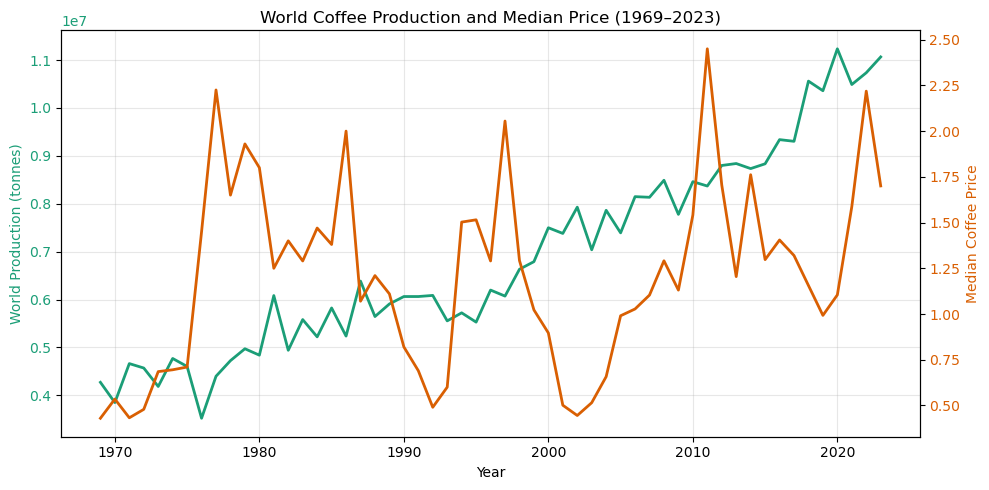

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Produção mundial (eixo esquerdo)
ax1.plot(
    df_world_price["year"],
    df_world_price["world_production"],
    color="#1b9e77",
    linewidth=2,
    label="World Production"
)
ax1.set_xlabel("Year")
ax1.set_ylabel("World Production (tonnes)", color="#1b9e77")
ax1.tick_params(axis="y", labelcolor="#1b9e77")

# Preço (eixo direito)
ax2 = ax1.twinx()
ax2.plot(
    df_world_price["year"],
    df_world_price["price_median"],
    color="#d95f02",
    linewidth=2,
    label="Median Coffee Price"
)
ax2.set_ylabel("Median Coffee Price", color="#d95f02")
ax2.tick_params(axis="y", labelcolor="#d95f02")

plt.title("World Coffee Production and Median Price (1969–2023)")
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Despite a sustained increase in global coffee production, prices remain volatile but lack a proportional long-term upward trend, indicating that productivity gains have played a central role in stabilizing global supply and moderating price pressures.

In [45]:
window=10
df_corr = df_world_price.sort_values("year").copy()
df_corr["prod_growth"] = df_corr["world_production"].pct_change()
df_corr["price_growth"] = df_corr["price_median"].pct_change()

df_corr["rolling_corr_growth"] = (
    df_corr["prod_growth"]
    .rolling(window)
    .corr(df_corr["price_growth"]))

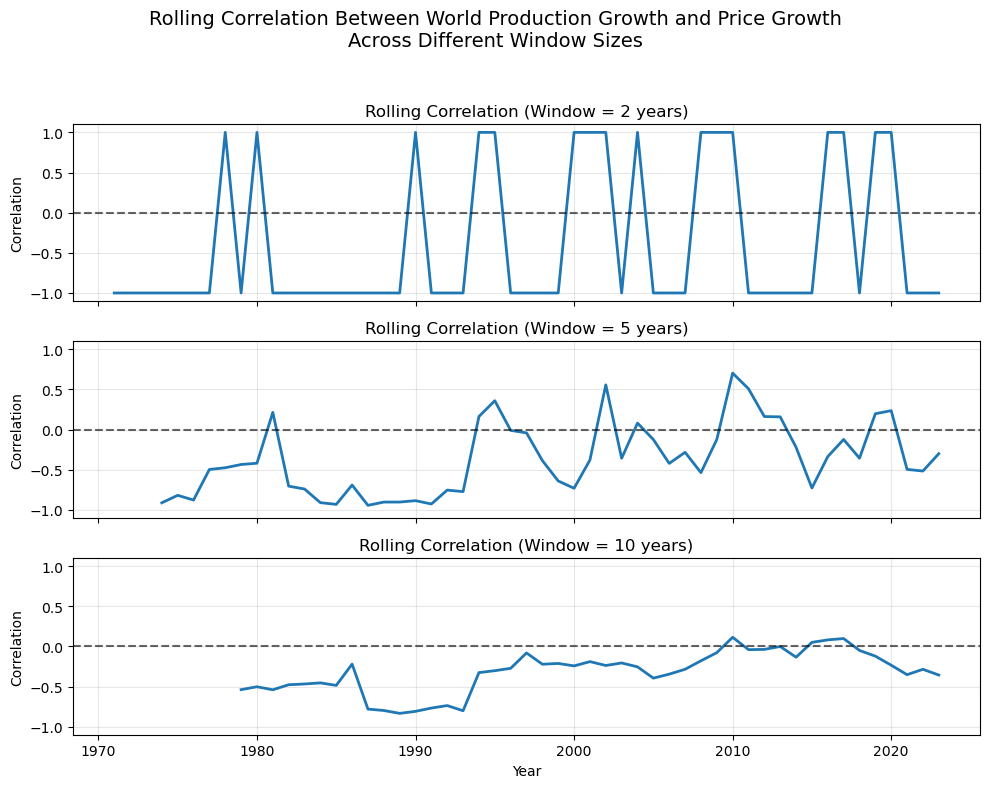

In [46]:
windows = [2, 5, 10]

fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(10, 8),
    sharex=True,
    sharey=True
)

for ax, window in zip(axes, windows):

    df_corr[f"rolling_corr_{window}"] = (
        df_corr["prod_growth"]
        .rolling(window)
        .corr(df_corr["price_growth"])
    )

    ax.plot(
        df_corr["year"],
        df_corr[f"rolling_corr_{window}"],
        linewidth=2,
        label=f"{window}-year window"
    )

    ax.axhline(0, color="black", linestyle="--", alpha=0.6)
    ax.set_ylabel("Correlation")
    ax.set_title(f"Rolling Correlation (Window = {window} year{'s' if window > 1 else ''})")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Year")

fig.suptitle(
    "Rolling Correlation Between World Production Growth and Price Growth\nAcross Different Window Sizes",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The figure presents the rolling correlation between global coffee production growth and price growth, computed using different window sizes. Comparing these windows highlights how the relationship between supply and prices depends strongly on the temporal scale considered.

- Short window (2 years)
With a 2-year window, the correlation exhibits extreme fluctuations, frequently reaching values close to +1 or −1. This behavior reflects high sensitivity to short-term shocks such as climatic events, inventory adjustments, speculation, and immediate market reactions. At this scale, the correlation is dominated by noise and does not provide a structural interpretation of the relationship between production and prices.

- Intermediate window (5 years)
When the window is extended to 5 years, the correlation becomes more stable, although it still displays substantial variability. At this horizon, more persistent episodes of negative correlation can be identified, suggesting periods in which production expansions were associated with downward pressure on prices. Nevertheless, the relationship remains unstable, indicating that short- to medium-term factors continue to play a relevant role.

- Long window (10 years)
With a 10-year window, the correlation stabilizes around slightly negative values or near zero for most of the period. This pattern indicates that, in the long run, growth in global coffee production does not translate automatically into proportional price declines or sustained price increases. Instead, the link between production and prices is weakened by productivity gains and structural adjustments on the supply side.

Overall interpretation
The comparison across window sizes shows that:

- In the short run, price movements are dominated by transitory shocks and do not directly reflect production dynamics.

- In the medium run, occasional signals of a negative relationship between production and prices emerge.

- In the long run, the correlation weakens, suggesting that productivity gains and supply elasticity mitigate price pressures.

- This evidence reinforces the view that coffee price volatility is largely driven by short-term and interannual factors, while productivity-driven supply growth contributes to stabilizing prices over the long term.

## Without Brazil
Hiphothesis

Brazil may function as a stabilizing component of global coffee supply due to its scale and productivity-driven growth. If Brazil is excluded from the global aggregate, the remaining supply is expected to exhibit greater sensitivity to production shocks, which could manifest as a stronger negative association between production growth and price movements.

Under this hypothesis, global price dynamics would be more elastic to supply variations originating outside Brazil, reflecting a reduced buffering effect in the non-Brazilian production system.

In [50]:
df_brazil = (
    df_fao[df_fao["Area"] == "Brazil"]
    [["Year", "Production"]]
    .rename(columns={
        "Year": "year",
        "Production": "brazil_production"
    })
)

df_world_ex_brazil = (
    df_world_prod
    .merge(df_brazil, on="year", how="inner")
)

df_world_ex_brazil["world_production_ex_brazil"] = (
    df_world_ex_brazil["world_production"]
    - df_world_ex_brazil["brazil_production"]
)

df_world_ex_brazil_price = (
    df_world_ex_brazil
    .merge(
        df_prices_yearly,
        on="year",
        how="inner"
    )
    .sort_values("year")
)



To isolate the role of Brazil in global supply dynamics, non-Brazilian production is computed as the difference between total world production and Brazilian production. This approach ensures accounting consistency and avoids biases arising from incomplete country coverage in the aggregation of individual producers.


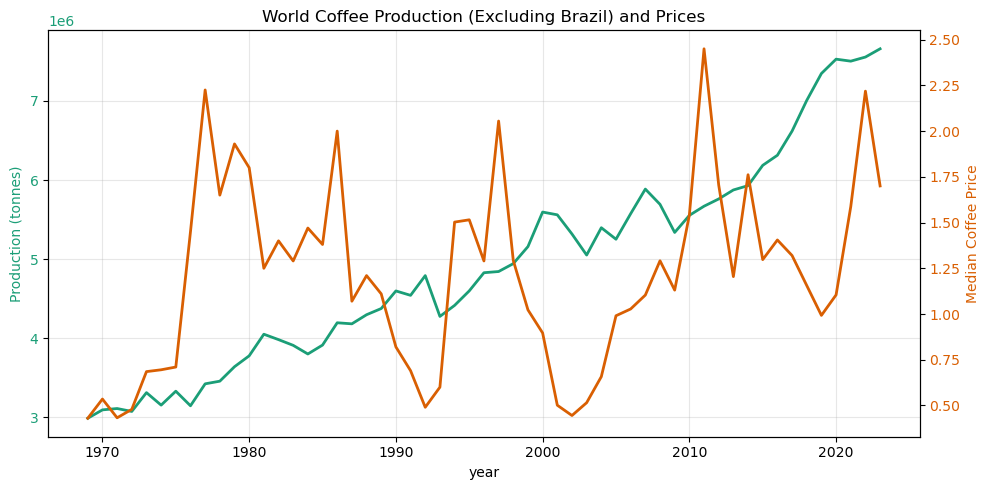

In [55]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Produção sem Brasil
ax1.plot(
    df_world_ex_brazil_price["year"],
    df_world_ex_brazil_price["world_production_ex_brazil"],
    color="#1b9e77",
    linewidth=2,
    label="World Production (ex Brazil)"
)
ax1.set_xlabel("year")
ax1.set_ylabel("Production (tonnes)", color="#1b9e77")
ax1.tick_params(axis="y", labelcolor="#1b9e77")

# Preço
ax2 = ax1.twinx()
ax2.plot(
    df_world_ex_brazil_price["year"],
    df_world_ex_brazil_price["price_median"],
    color="#d95f02",
    linewidth=2,
    label="Median Coffee Price"
)
ax2.set_ylabel("Median Coffee Price", color="#d95f02")
ax2.tick_params(axis="y", labelcolor="#d95f02")

ax1.grid(True, alpha=0.3)
plt.title("World Coffee Production (Excluding Brazil) and Prices")
plt.tight_layout()
plt.show()

When Brazilian production is removed from the global aggregate, the relationship between supply and prices becomes visually clearer.

Non-Brazilian world production shows a steadily increasing long-term trend, driven by gradual expansion and productivity gains in other producing countries. In contrast, median coffee prices exhibit sharp cyclical fluctuations, with pronounced spikes and collapses that are not mirrored by equivalent short-term changes in production.

Several periods illustrate this divergence. For instance, during major price spikes (late 1970s, late 1990s, early 2010s), non-Brazilian production continues to grow or remains relatively stable, suggesting that prices respond more strongly to supply shocks, expectations, inventories, and market conditions than to contemporaneous changes in aggregate output.

Compared to the full world aggregate, excluding Brazil amplifies the apparent sensitivity of prices to production dynamics. This supports the interpretation that Brazil plays a stabilizing role in the global coffee market, smoothing supply through productivity improvements and scale, thereby dampening the transmission of supply fluctuations into prices when included in the world total.

Overall, the figure reinforces that:

- Price volatility is largely decoupled from smooth long-term production growth.

- Short- to medium-term price movements reflect market shocks rather than gradual supply expansion.

- Removing Brazil reveals a more elastic and volatile supply-price relationship in the rest of the world.

In [60]:
window = 10

df_corr_compare = (
    df_world_ex_brazil_price
    .sort_values("year")
    .copy()
)

# Crescimento da produção
df_corr_compare["world_prod_growth"] = (
    df_corr_compare["world_production"].pct_change()
)

df_corr_compare["world_ex_br_prod_growth"] = (
    df_corr_compare["world_production_ex_brazil"].pct_change()
)

# Crescimento do preço
df_corr_compare["price_growth"] = (
    df_corr_compare["price_median"].pct_change()
)


df_corr_compare["corr_world"] = (
    df_corr_compare["world_prod_growth"]
    .rolling(window)
    .corr(df_corr_compare["price_growth"])
)

df_corr_compare["corr_world_ex_brazil"] = (
    df_corr_compare["world_ex_br_prod_growth"]
    .rolling(window)
    .corr(df_corr_compare["price_growth"])
)



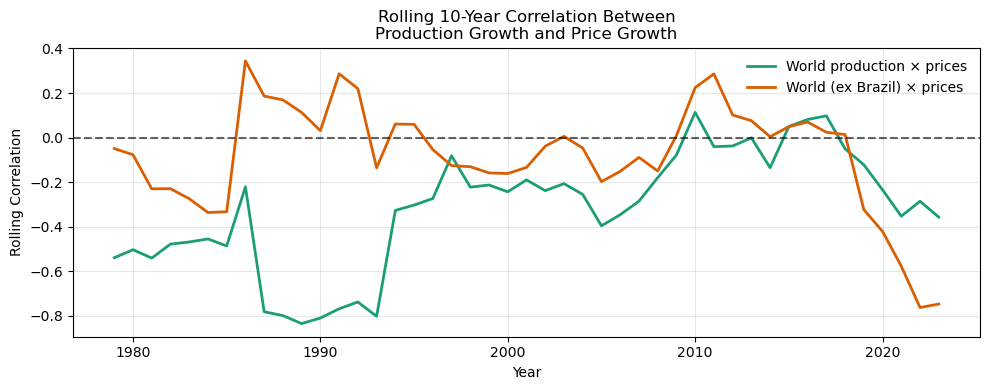

In [61]:
plt.figure(figsize=(10, 4))

plt.plot(
    df_corr_compare["year"],
    df_corr_compare["corr_world"],
    label="World production × prices",
    color="#1b9e77",
    linewidth=2
)

plt.plot(
    df_corr_compare["year"],
    df_corr_compare["corr_world_ex_brazil"],
    label="World (ex Brazil) × prices",
    color="#d95f02",
    linewidth=2
)

plt.axhline(0, color="black", linestyle="--", alpha=0.6)

plt.xlabel("Year")
plt.ylabel("Rolling Correlation")
plt.title(
    "Rolling 10-Year Correlation Between\nProduction Growth and Price Growth"
)

plt.legend(frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


When Brazil is included, the correlation is predominantly negative but relatively stable over time. This indicates that increases in global production tend to be associated with downward pressure on prices, yet the magnitude of this relationship is moderated. The smoother trajectory suggests that global supply growth, when dominated by Brazil, does not translate directly into large price swings.

In contrast, excluding Brazil results in a more volatile and, in recent decades, more strongly negative correlation. From the mid-2010s onward, the correlation for World (ex Brazil) becomes substantially more negative, indicating that expansions in non-Brazilian production are more closely aligned with price declines. This suggests a higher sensitivity of prices to supply changes originating outside Brazil.

The divergence between the two curves highlights Brazil’s stabilizing role in the global coffee market. Brazil’s ability to expand output through productivity gains and scale appears to dampen the transmission of supply fluctuations into prices. When Brazil is removed, global supply becomes less elastic and more exposed to shocks, strengthening the observed negative association between production growth and prices.

Overall, the analysis indicates that the supply–price relationship in the coffee market is not uniform across producers and depends critically on the composition of global production, rather than on aggregate supply alone.